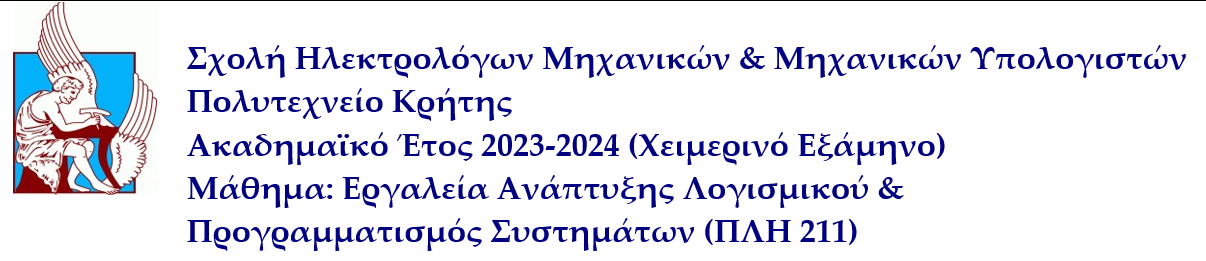

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Εργασία 1 - Θέμα: Ανάπτυξη Λογισμικού Aggregative News Analyzer

---
⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰
# ΔΕΝ προχωράμε παρακάτω σε αυτό το notebook αν δεν έχουμε διαβάσει και είμαστε έτοιμοι να εφαρμόσουμε ακριβώς τις οδηγίες που διανέμονται μαζί με αυτή την εργασία στο PLH211_Project1_2023_2024_Directions.docx.
---
⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰

<font color='red'> Στα πλαίσια της εργασίας δεν μπορείτε να υποθέσετε ότι τα news και άρα τα αρχεία που σας δίδονται δεν αλλάζουν ποτέ. Το αρχείο με τα news θεωρείται μεταβλητό καθώς σε ένα πραγματικό σενάριο τα news ανανεώνονται σε τακτά χρονικά διαστήματα. Άρα δεν μπορείτε να προ-υπολογίσετε το Jaccard Index και όσα άλλα ζητούνται μόνο μια φορά και να τα σώσετε μια μόνο φορά σε αρχείο.</font>  

# Development Phase

## ⏩ Κώδικας Development Phase
Γράψτε στο παρακάτω code cell όλο τον κώδικα που υλοποιεί τον Aggregative News Analyzer σας.

In [3]:
from openpyxl import Workbook
import json
import sys

def read_category_docid(file_path):
  """This function basically reads the category-doc_id pairs
  from the given file and keeps the data in a LIST, which later
  on is returned, this way the programmer can access the data"""
  data = []
  with open(file_path, 'r') as file:
      for line in file:
          columns = line.split()[:2]  # Extract the first two columns
          data.append(columns)
  return data


def read_docid_tid(file_path):
    """This function reads the doc_id-tids pairs from the given file
    and returns the data as a list of tuples."""
    docid_tid_list = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            doc_id = parts[0]
            tids = [term.split(':')[0] for term in parts[1:]]
            # Appending the doc_id and tids as a tuple to the list
            docid_tid_list.append((doc_id, tids))

    return docid_tid_list


def read_stem_tid(file_path):
    """This function reads the stem-tid pairs from the given file
    and returns the data as a list."""
    stem_list = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            stem, tid = parts[0], parts[1]
            # Appending the stem and tid as a tuple to the list
            stem_list.append((stem, tid))

    return stem_list


def doc_t(term, term_list):
    """This function is used to calculate the documents
    where the term given as an argument is located."""
    target_tid = term
    subset = [(doc_id) for doc_id, tids in term_list if target_tid in tids]
    return subset


def doc_c(category, category_list):
    """This function is used to calculate the documents
    that belong to the given category."""
    target_category = category
    subset = [(docid) for categories, docid in category_list if target_category in categories ]
    return subset


def list_intersection(list1, list2):
    """Calculate the intersection of two lists."""
    return list(set(list1) & set(list2))


def list_union(list1, list2):
    """Calculate the union of two lists."""
    return list(set(list1) | set(list2))


def cardinality(my_list):
    """Calculate the cardinality of the given list"""
    return len(my_list)


def jaccard_index(list1, list2):
    """Calculate the Jaccard Index.
    It returns the Jaccard Index, or -1 if the value is not in the [0, 1] range.
    """
    intersection = list_intersection(list1, list2)
    union = list_union(list1, list2)

    intersection_cardinality = cardinality(intersection)
    union_cardinality = cardinality(union)
    if (union_cardinality != 0):
      index = intersection_cardinality / union_cardinality
    else:
      index = 0
    if index <0 or index >1:
      result = -1
    else:
        result = index
    return result


def find_tid(stem,stem_tid_map):
  """Finds the tid from the given stem"""
  target_stem = stem
  term_id = ''
  for stem, tid in stem_tid_map:
    if stem==target_stem:
      term_id = tid
  return term_id


def calculate_jaccard_index_for_stem_category(stem, category, category_list, term_list, stem_tid_map):
  """This function returns the Jaccard index for a stem and category"""
  term_id = find_tid(stem,stem_tid_map)
  # Find documents containing the given term
  term_documents = doc_t(term_id, term_list)
  # Find documents belonging to the given category
  category_documents = doc_c(category, category_list)
  # Calculate the Jaccard Index
  jaccard_score = jaccard_index(term_documents, category_documents)
  return jaccard_score


def find_top_k_stems_for_category(category, k, category_list, term_list, stem_tid_map):
  """This function returns the top k stems of the given category
  based on Jaccard index"""
  category_documents = doc_c(category, category_list)
  if len(category_documents) == 0:
    print(f"No category named {category}")
    return
  if k>len(stem_tid_map):
    print(f"k={k}, out of range, max number of stems = {len(stem_tid_map)}")
    return
  stem_jaccard_scores = {}
  for stem, tid in stem_tid_map:
    stem_documents = doc_t(tid, term_list)
    jaccard_score = jaccard_index(stem_documents, category_documents)
    stem_jaccard_scores[stem] = jaccard_score

  # Sort the top-k stems based on their Jaccard scores
  top_k_stems = sorted(stem_jaccard_scores, key=stem_jaccard_scores.get, reverse=True)[:k]
  return top_k_stems


def find_top_k_categories_for_stem(stem, k, category_list, term_list, stem_tid_map):
  """This function returns the top k categories based on Jaccard index"""
  term_id = find_tid(stem,stem_tid_map)
  term_documents = doc_t(term_id, term_list)
  if len(term_documents) == 0:
    print(f"No stem named {stem}")
    return
  if k>len(category_list):
    print(f"k={k}, out of range, max number of categories = {len(category_list)}")
    return

  category_jaccard_scores = {}

  for category , docid in category_list:
    category_documents = doc_c(category, category_list)
    jaccard_score = jaccard_index(term_documents, category_documents)
    category_jaccard_scores[category] = jaccard_score

  # Sort top-k categories based on their Jaccard scores
  top_k_categories = sorted(category_jaccard_scores, key=category_jaccard_scores.get, reverse=True)[:k]
  return top_k_categories


def show_stems_for_doc_id(doc_id, docid_tid_map, stem_tid_map):
    """This function prints all the stems that are contained in the document with the given doc_id"""
    counter = 0
    tids_for_doc=[]
    stems_of_doc=[]
    for docid , tid in docid_tid_map:
      if doc_id == docid:
        for term_id in tid:
          tids_for_doc.append(term_id)
        for ext_tid in tids_for_doc:
          for stem, tid2 in stem_tid_map:
             if tid2 == ext_tid:
              stems_of_doc.append(stem)
              counter = counter + 1
              break
        print(f"Stems containing document ID {doc_id}:")
        for stem in stems_of_doc:
            print(stem)
        break
    if(counter == 0):
      print(f"No stems found for document ID {doc_id}")
    return


def show_categories_for_doc_id(doc_id, category_list):
    """This function prints the categories that are assigned to the given doc_id"""
    # Check if doc_id exists in the list of tuples
    if not any(did == doc_id for _, did in category_list):
        print(f"No categories found for document ID {doc_id}")
        return
    assigned_categories = [category for category, did in category_list if did == doc_id]
    print(f"Categories assigned to document ID {doc_id}:")
    for category in assigned_categories:
        print(category)


def create_file(filename, filetype, category_list ,term_list, stem_tid_map):
    """
    Create a file (either .json or .xlsx) based on the specified filename and filetype.
    The file contains all the pairs (category,stem) and their JaccardIndex.
    """
    #extracting only the categories into a new variable
    categories_only = [category for category,docid in category_list]
    data = set()

    for stem, tid in stem_tid_map:
      for category in categories_only:
        jaccard_score = jaccard_index(doc_t(tid, term_list), doc_c(category, category_list))
        data.add((stem, category, float(jaccard_score)))

    if filetype not in ['json', 'xlsx']:
        print("Invalid filetype. Only 'json', 'xlsx' are supported.")
        return
    if filetype == 'json':
        with open(f"{filename}.json", 'w') as json_file:
            json.dump(list(data), json_file, indent=2) #indent=2 for easier readability of the json file
        print(f"JSON file '{filename}.json' created successfully.")
    elif filetype == 'xlsx':
        wb = Workbook()
        ws = wb.active
        ws.append([ "Stem", "Category", "Jaccard Index"])
        for stem, category, jaccard_index_value in data:
            ws.append([stem, category, jaccard_index_value])
        wb.save(f"{filename}.xlsx")
        print(f"Excel file '{filename}.xlsx' created successfully.")
    return


def count_terms_of_doc(doc_id, docid_tid_map):
  """This function counts the number of unique terms are contained in the document with the given doc_id"""
  target_sublist = []
  for d_id, tids in docid_tid_map:
      if d_id == doc_id:
          target_sublist = tids
          break
  #make sure list is not empty
  if target_sublist is not None:
    #convert the list to a set() in order to remove duplicates
    count = len(set(target_sublist))
    print(f"The count of unique terms for document ID {doc_id} is {count}.")
  else:
    print(f"No data found for document ID {doc_id}.")
  return


def count_categories_of_doc(doc_id ,categories_did_map):
  """This function counts the number of categories assigned to the document with the given doc_id"""
  count=0
  for category,docid in categories_did_map:
    if docid == doc_id:
      count=count+1
  print(f"The count of categories for document ID {doc_id} is {count}.")
  return


def handle_option1(option, did,term_list, stem_tid_map,category_list):
  """This function shows stems or categories if user give input = -t or -c"""
  if option == '-t':
    print("Option '-t' selected.")
    show_stems_for_doc_id(did, term_list, stem_tid_map)
  elif option == '-c':
    print("Option '-c' selected.")
    show_categories_for_doc_id(did, category_list)
  else:
    print("Invalid option.")


def handle_option2(option, did,term_list, stem_tid_map,category_list):
  """This function counts tids or categories if user gives input = -t or -c"""
  if option == '-t':
    print("Option '-t' selected.")
    count_terms_of_doc(did, term_list)
  elif option == '-c':
    print("Option '-c' selected.")
    count_categories_of_doc(did, category_list)
  else:
    print("Invalid option.")

def menu(stem_tid_path,category_path,tid_path):
  """This function recursively prints the Driver Program menu"""
  category_list = read_category_docid(category_path)
  term_list = read_docid_tid(tid_path)
  stem_tid_map = read_stem_tid(stem_tid_path)

  print('-------------------------------- Aggregative News Analyzer Menu --------------------------------')
  print('                                                                                                ')
  print('---------Commands-------------------------------Details-----------------------------------------')
  print('-     @ <category> <k>           Show me the <k> most relevant (based on Jaccard Index) stems  -')
  print('-                                (not tid) for the category <category>                         -')
  print('------------------------------------------------------------------------------------------------')
  print('-     # <stem> <k>               Show me the <k> most relevant (based on Jaccard Index)        -')
  print('-                                categories for the <stem>                                     -')
  print('------------------------------------------------------------------------------------------------')
  print('-     $ <stem> <category>        Show me the Jaccard Index of the specific (stem,              -')
  print('-                                category) pair                                                -')
  print('------------------------------------------------------------------------------------------------')
  print('-     * <filename>.<filetype>    Save to a file with the name <filename>.<filetype> ALL        -')
  print('-                                (category, stem) pairs along with their Jaccard Index. The    -')
  print('-                                filename will be a user-provided string, while the filetype   -')
  print('-                                provided by the user can be one of {json, xlsx}, and the      -')
  print('-                                file, where the results will be saved, should be created      -')
  print('-                                accordingly as a json or excel file based on what was shown   -')
  print('-                                in the respective lecture. For example, in the excel file,    -')
  print('-                                we will have 3 columns with corresponding names, and in the   -')
  print('-                                json, we will have 3 fields with corresponding names and      -')
  print('-                                values.                                                       -')
  print('------------------------------------------------------------------------------------------------')
  print('-      P <did> -c|-t             If the “-t” switch is used in the command, then show me all   -')
  print('-                                the stems contained in the document with code did. If the     -')
  print('-                                “-c” switch is used in the command, then show me all the      -')
  print('-                                categories assigned to the document with code did.            -')
  print('------------------------------------------------------------------------------------------------')
  print('-      C <did> -c|-t             If the “-t” switch is used in the command, count and show me  -')
  print('-                                on the screen how many (count) unique terms the document      -')
  print('-                                with code did contains. If the “-c” switch is used in the     -')
  print('-                                command, count and show me on the screen how many (count)     -')
  print('-                                categories are assigned to the document with code did.        -')
  print('------------------------------------------------------------------------------------------------')
  print('-       X                        Exit                                                          -')
  print('------------------------------------------------------------------------------------------------')

  command = input("Enter your command: ")

  if command == "@":
    # Ask the user for the parameters the function needs
    category = input("Please enter the category: ")
    k = int(input("Please enter the number of stems (k): "))
    # Calling the function find_top_k_stems_for_category to do the action that is asked
    top_k_stems = find_top_k_stems_for_category(category,k,category_list,term_list, stem_tid_map)
    # Print the results
    if top_k_stems == None :
      menu(stem_tid_path,category_path,tid_path)
    print(f"Top {k} stems for category '{category}':")
    for stem in top_k_stems:
      print(stem)

    print("Action completed!")
    menu(stem_tid_path,category_path,tid_path)

  elif command == "#":
    # Ask the user for the parameters the function needs
    stem = input("Please enter the stem: ")
    k = int(input("Please enter the number of categories (k): "))
    # Calling the function find_top_k_stems_for_category to do the action that is asked
    top_k_categories = find_top_k_categories_for_stem(stem,k,category_list ,term_list, stem_tid_map)
    # Print the results
    if top_k_categories == None :
      menu(stem_tid_path,category_path,tid_path)
    print(f"Top {k} categories for stem '{stem}':")
    for category in top_k_categories:
      print(category)
    print("Action completed!")
    menu(stem_tid_path,category_path,tid_path)

  elif command == "$":
    # Ask the user for the parameters the function needs
    stem = input("Please enter the stem: ")
    category = input("Please enter the category: ")
    # Calling the function find_top_k_stems_for_category to do the action that is asked
    jaccard_score = calculate_jaccard_index_for_stem_category(stem,category,category_list, term_list, stem_tid_map)
    # Print the result
    print(f"Jaccard Index for stem '{stem}' and category '{category}': {jaccard_score}")
    print("Action completed!")
    menu(stem_tid_path,category_path,tid_path)

  elif command == "*":
    # Ask the user for the parameters the function needs
    filename = input("Please enter the filename: ")
    filetype = input("Please enter the filetype: ")
    # Calling the function create_file to do the action that is asked
    create_file(filename,filetype, category_list2,term_list2, stem_tid_map2)
    print("Action completed!")
    menu(stem_tid_path,category_path,tid_path)

  elif command == "P":
    # Ask the user for the parameters the function needs
    did = input("Please enter the document_id: ")
    option = input("Please enter '-t' or '-c': ")
    # Call the function for option parameter
    handle_option1(option, did,term_list, stem_tid_map,category_list)
    print("Action completed!")
    menu(stem_tid_path,category_path,tid_path)

  elif command == "C":
    # Ask the user for the parameters the function needs
    did = input("Please enter the document_id: ")
    option = input("Please enter '-t' or '-c': ")
    # Call the function for option parameter
    handle_option2(option, did,term_list, stem_tid_map,category_list)
    print("Action completed!")
    menu(stem_tid_path,category_path,tid_path)

  elif command == "X":
    print("Thanks for using our program!")
    exit()

  else:
    print("Please enter a valid input: ")
    menu(stem_tid_path,category_path,tid_path)


def main():
   # Ask the user for the parameters the function needs
   stem_tid_path = input("Please enter the path for STEM_TID text_file: ")
   # Ask the user for the parameters the function needs
   category_path = input("Please enter the path for CATEGORY text_file: ")
   # Ask the user for the parameters the function needs
   tid_path = input("Please enter the path for TID text_file: ")
   menu(stem_tid_path,category_path,tid_path)


if __name__ == "__main__":
  sys.exit(main())




Please enter the path for STEM_TID text_file: /content/drive/MyDrive/Tropopoihmena_text/stem.termid.idf.map.txt
Please enter the path for CATEGORY text_file: /content/drive/MyDrive/Tropopoihmena_text/rcv1-v2.topics.qrels.txt
Please enter the path for TID text_file: /content/drive/MyDrive/Tropopoihmena_text/lyrl2004_vectors_train.dat.txt
-------------------------------- Aggregative News Analyzer Menu --------------------------------
                                                                                                
---------Commands-------------------------------Details-----------------------------------------
-     @ <category> <k>           Show me the <k> most relevant (based on Jaccard Index) stems  -
-                                (not tid) for the category <category>                         -
------------------------------------------------------------------------------------------------
-     # <stem> <k>               Show me the <k> most relevant (based on Jaccar

SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Developement Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Development Phase στο προηγούμενο code cell (H τεκμηρίωση βαθμολογείται).

**Ο παραπάνω κώδικας ουσιαστικά υλοποιεί έναν *Aggregative News Analyzer*.**

✅ Πρόκειται για ένα driver program το οποίο  δίνει στο χρήστη τη δυνατότητα να κάνει ερωτήσεις συγκεντρωτικής ανάλυσης του αρχείου των ειδήσεων, αυτό επιτυγχάνεται μέσω της συνάρτησης *menu()*.   

>Η συνάρτηση **menu()** πρόκειται για μια αναδρομική συνάρτηση η οποία καλέι ξανά και ξανά τον εαυτό της εώς ότου ο χρήστης να δώσει εντολή εξόδου. Στην περίπτωση που δεν επιλεχθεί η εντολή εξόδου, ο χρήστης καλείται να δίνει ως είσοδο στο πρόγραμμα κάθε φορά την εντολή που θέλει να εκτελέσει και ανάλογα με την είσοδό του ,το πρόγραμμα "θα μπαίνει" στην κατάλληλη περίπτωση (if-elif...).


---




✅ Ένα κομβικό σημείο για την σωστή λειτουργία του προγράμματος είναι η ανάγνωση των δεδομένων που υπάρχουν στα αρχεία. Αυτό γίνεται από τις συναρτήσεις:


>**read_category_docid(file_path)** :
Διαβάζει τα δεδομένα του ASCII αρχείου *rcv1-v2.topics.qrels.txt*. Η συνάρτηση επιστρέφει λίστα όπου κάθε στοιχείο είναι λίστα 2 στοιχείων.  *ΠΧ: [['E11', '2286'], ['ECAT', '2286'], ['M11', '2286'],....*.


>**read_docid_tid(file_path)** : Είναι υπεύθυνη για το διάβασμα ASCII αρχείων με ονόματα της μορφής *lyrl2004_vectors_test_pt*.dat.gz.*.Η συνάρτηση επιστρέφει μια λίστα από Tuples που περιέχει τα δεδομένα αυτά,    *ΠΧ: [('2286', ['1523', '2293', '2621', '2828', '2964', '4028', '4392'...*

>**read_stem_tid(file_path)** : Διαβάζει από το *stem.termid.idf.map.txt* και επιστρέφει τα δεδομένα σε μια λίστα, *ΠΧ: [('a0', '7'), ('a1', '8'), ('a123', '9'), ('a2', '10'),...*



---

✅ Οι παραπάνω συναρτήσεις καλούνται στην αρχή της menu(). Ίσως αυτό να μπορεί να βελτιωθεί.. θα το δούμε παρακάτω στο Refactoring Phase.

---
✅  Γενικά, ο "πυρήνας" του προγράμματος είναι ο υπολογισμός του βαθμού σχετικότητας κάθε term με κάθε category. Αυτό το πετυχαίνουμε με χρήση του Jaccard Index Score. Για τον υπολογισμό του Jaccard Score γίνεται χρήση των συναρτήσεων :

>*   *doc_c(category, category_list)*
*   *doc_t(term, term_list)*
*   *list_intersection(list1, list2)*
*   *list_union(list1, list2)*
*   *cardiinality(my_list)*
*   και τέλος *jaccard_index(list1, list2)*

Η λειτουργικότητα των τελευταίων 4 συναρτήσεων είναι αυτονόητη. Η συνάρτηση doc_c ουσιαστικά, επιστρέφει το (υπο)σύνολο των documents (από το αρχείο *rcv1-v2.topics.qrels.txt*) που περιέχονται στην κατηγορία που category, και η doc_t επιστρέφει το (υπο)σύνολο των documents που περιέχουν τον όρο term.


---


✅ Έχοντας τα παραπάνω διαθέσιμα , η υλοποίηση των συναρτήσεων έγινε ακολουθόντας την περιγραφή που δίνεται από την εκφώνηση για κάθε περίπτωση.


---


✍ Πριν την συγγραφή του κώδικα για το Development Phase έγινε καλή μελέτη των διαλέξεων 1 και 4.


---

✍ Κατά το διάβασμα του αρχείου ASCII *file rcv1-v2.topics.qrels.txt* ,όπου η κάθε εγγραφή έχει την μορφή: "category" "documentid" "1", το "1" αγνοείται με το να διαβάζονται μόνο οι δύο πρώτες στήλες


```
      for line in file:
          columns = line.split()[:2]  # Extract the first two columns
```

---


✍ Κατά το διάβασμα του αρχείου ASCII *stem.termid.idf.map.txt* ,όπου η κάθε εγγραφή έχει τη μορφή "stem" "tid" "idf" , το "idf" αγνοείται ως εξής:
```
for line in file:
            parts = line.strip().split()
            stem, tid = parts[0], parts[1]
```





---


✍ Στην εκφώνηση ζητήθηκε το menu να υλοποιείται μέσα σε μια while true loop, αλλά εμείς αποφασίσαμε να φτιάξουμε μια συνάρτηση menu() η οποία στο τέλος κάθε if (δηλαδή στο τέλος κάθε περίπτωσης) να ξανακαλεί αναδρομικά τον εαυτό της, και στην περίπτωση του exit να κάνει απλά return.

# Logging Phase


## ⏩ Κώδικας Logging Phase
Γράψτε στο παρακάτω code cell όλο τον κώδικα που φτιάχνει το myeditorlog.conf αρχείο με το configuration (loggers, handlers, formatters) του logger σας.

`format=%(asctime)s - %(name)s - %(levelname)s - %(message)s `

In [ ]:
%%file myeditorlog.conf

[loggers]
keys = root

[logger_root]
handlers = file
level = NOTSET

[formatters]
keys = complex

[formatter_complex]
format = %(asctime)s - %(name)s - %(levelname)s - %(message)s

[handlers]
keys=file

[handler_file]
class = FileHandler
interval = midnight
backupCount = 5
formatter=complex
level=INFO
args=('logme.txt','w')

Writing myeditorlog.conf


Γράψτε στο παρακάτω code cell τον κώδικα του Aggregative News Analyzer όπως ήταν στο Developement phase ΑΛΛΑ εδώ θα έχει και εισαγωγή των κατάλληλων εντολών που δημιουργούν τα LogRecords ώστε αυτά να γράφονται σε ένα αρχείο logme.txt .

In [ ]:
from openpyxl import Workbook
import json
import sys

#extras for logging:
import logging
import logging.config

logging.config.fileConfig(fname = 'myeditorlog.conf', disable_existing_loggers = False)
# Get the logger specified in the file
logger = logging.getLogger(__name__)

def read_category_docid(file_path):
  """This function basically reads the category-doc_id pairs
  from the given file and keeps the data in a LIST, which later
  on is returned, this way the programmer can access the data"""
  data = []
  with open(file_path, 'r') as file:
      for line in file:
          columns = line.split()[:2]  # Extract the first two columns
          data.append(columns)
  return data


def read_docid_tid(file_path):
    """This function reads the doc_id-tids pairs from the given file
    and returns the data as a list of tuples."""
    docid_tid_list = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            doc_id = parts[0]
            tids = [term.split(':')[0] for term in parts[1:]]
            # Appending the doc_id and tids as a tuple to the list
            docid_tid_list.append((doc_id, tids))

    return docid_tid_list


def read_stem_tid(file_path):
    """This function reads the stem-tid pairs from the given file
    and returns the data as a list."""
    stem_list = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            stem, tid = parts[0], parts[1]
            # Appending the stem and tid as a tuple to the list
            stem_list.append((stem, tid))

    return stem_list


def doc_t(term, term_list):
    """This function is used to calculate the documents
    where the term given as an argument is located."""
    target_tid = term
    subset = [(doc_id) for doc_id, tids in term_list if target_tid in tids]
    return subset


def doc_c(category, category_list):
    """This function is used to calculate the documents
    that belong to the given category."""
    target_category = category
    subset = [(docid) for categories, docid in category_list if target_category in categories ]
    return subset


def list_intersection(list1, list2):
    """Calculate the intersection of two lists."""
    return list(set(list1) & set(list2))


def list_union(list1, list2):
    """Calculate the union of two lists."""
    return list(set(list1) | set(list2))


def cardinality(my_list):
    """Calculate the cardinality of the given list"""
    return len(my_list)


def jaccard_index(list1, list2):
    """Calculate the Jaccard Index.
    It returns the Jaccard Index, or -1 if the value is not in the [0, 1] range.
    """
    intersection = list_intersection(list1, list2)
    union = list_union(list1, list2)

    intersection_cardinality = cardinality(intersection)
    union_cardinality = cardinality(union)
    if (union_cardinality != 0):
      index = intersection_cardinality / union_cardinality
    else:
      index = 0
    if index <0 or index >1:
      result = -1
    else:
        result = index
    return result


def find_tid(stem,stem_tid_map):
  """Finds the tid from the given stem"""
  target_stem = stem
  term_id=''
  for stem, tid in stem_tid_map:
    if stem==target_stem:
      term_id = tid
  return term_id


def calculate_jaccard_index_for_stem_category(stem, category, category_list, term_list, stem_tid_map):
  """This function returns the Jaccard index for a stem and category"""
  term_id = find_tid(stem,stem_tid_map)
  # Find documents containing the given term
  term_documents = doc_t(term_id, term_list)
  # Find documents belonging to the given category
  category_documents = doc_c(category, category_list)
  # Calculate the Jaccard Index
  jaccard_score = jaccard_index(term_documents, category_documents)
  return jaccard_score


def find_top_k_stems_for_category(category, k, category_list, term_list, stem_tid_map):
  """This function returns the top k stems of the given category
  based on Jaccard index"""
  category_documents = doc_c(category, category_list)
  if len(category_documents) == 0:
    print(f"No category named {category}")
    return
  if k>len(stem_tid_map):
    print(f"k={k}, out of range, max number of stems = {len(stem_tid_map)}")
    return
  stem_jaccard_scores = {}
  for stem, tid in stem_tid_map:
    stem_documents = doc_t(tid, term_list)
    jaccard_score = jaccard_index(stem_documents, category_documents)
    stem_jaccard_scores[stem] = jaccard_score

  # Sort the top-k stems based on their Jaccard scores
  top_k_stems = sorted(stem_jaccard_scores, key=stem_jaccard_scores.get, reverse=True)[:k]
  return top_k_stems


def find_top_k_categories_for_stem(stem, k, category_list, term_list, stem_tid_map):
  """This function returns the top k categories based on Jaccard index"""
  term_id = find_tid(stem,stem_tid_map)
  term_documents = doc_t(term_id, term_list)
  if len(term_documents) == 0:
    print(f"No stem named {stem}")
    return
  if k>len(category_list):
    print(f"k={k}, out of range, max number of categories = {len(category_list)}")
    return

  category_jaccard_scores = {}

  for category , docid in category_list:
    category_documents = doc_c(category, category_list)
    jaccard_score = jaccard_index(term_documents, category_documents)
    category_jaccard_scores[category] = jaccard_score

  # Sort top-k categories based on their Jaccard scores
  top_k_categories = sorted(category_jaccard_scores, key=category_jaccard_scores.get, reverse=True)[:k]
  return top_k_categories




def show_stems_for_doc_id(doc_id, docid_tid_map, stem_tid_map):
    """This function prints all the stems that are contained in the document with the given doc_id"""
    counter = 0
    tids_for_doc=[]
    stems_of_doc=[]
    for docid , tid in docid_tid_map:
      if doc_id == docid:
        for term_id in tid:
          tids_for_doc.append(term_id)
        for ext_tid in tids_for_doc:
          for stem, tid2 in stem_tid_map:
             if tid2 == ext_tid:
              stems_of_doc.append(stem)
              counter = counter + 1
              break
        print(f"Stems containing document ID {doc_id}:")
        for stem in stems_of_doc:
            print(stem)
        break
    if(counter == 0):
      print(f"No stems found for document ID {doc_id}")
    return


def show_categories_for_doc_id(doc_id, category_list):
    """This function prints the categories that are assigned to the given doc_id"""
    # Check if doc_id exists in the list of tuples
    if not any(did == doc_id for _, did in category_list):
        print(f"No categories found for document ID {doc_id}")
        return
    assigned_categories = [category for category, did in category_list if did == doc_id]
    print(f"Categories assigned to document ID {doc_id}:")
    for category in assigned_categories:
        print(category)


def create_file(filename, filetype, category_list ,term_list, stem_tid_map):
    """
    Create a file (either .json or .xlsx) based on the specified filename and filetype.
    The file contains all the pairs (category,stem) and their JaccardIndex.
    """
    #extracting only the categories into a new variable
    categories_only = [category for category,docid in category_list]
    data = set()

    for stem, tid in stem_tid_map:
      for category in categories_only:
        jaccard_score = jaccard_index(doc_t(tid, term_list), doc_c(category, category_list))
        data.add((stem, category, float(jaccard_score)))

    if filetype not in ['json', 'xlsx']:
        print("Invalid filetype. Only 'json', 'xlsx' are supported.")
        return
    if filetype == 'json':
        with open(f"{filename}.json", 'w') as json_file:
            json.dump(list(data), json_file, indent=2) #indent=2 for easier readability of the json file
        print(f"JSON file '{filename}.json' created successfully.")
    elif filetype == 'xlsx':
        wb = Workbook()
        ws = wb.active
        ws.append([ "Stem", "Category", "Jaccard Index"])
        for stem, category, jaccard_index_value in data:
            ws.append([stem, category, jaccard_index_value])
        wb.save(f"{filename}.xlsx")
        print(f"Excel file '{filename}.xlsx' created successfully.")
    return




def count_terms_of_doc(doc_id, docid_tid_map):
  """This function counts the number of unique terms are contained in the document with the given doc_id"""
  target_sublist = []
  for d_id, tids in docid_tid_map:
      if d_id == doc_id:
          target_sublist = tids
          break
  #make sure list is not empty
  if target_sublist is not None:
    #convert the list to a set() in order to remove duplicates
    count = len(set(target_sublist))
    print(f"The count of unique terms for document ID {doc_id} is {count}.")
  else:
    print(f"No data found for document ID {doc_id}.")
  return


def count_categories_of_doc(doc_id ,categories_did_map):
  """This function counts the number of categories assigned to the document with the given doc_id"""
  count=0
  for category,docid in categories_did_map:
    if docid == doc_id:
      count=count+1
  print(f"The count of categories for document ID {doc_id} is {count}.")
  return


def handle_option1(option, did,term_list, stem_tid_map,category_list) :
  """This function shows stems or categories if user give input = -t or -c"""
  if option == '-t':
    logging.info(f"User chose see all the stems that contain the document with doc_id={did}")
    print("Option '-t' selected.")
    show_stems_for_doc_id(did, term_list, stem_tid_map)
  elif option == '-c':
    logging.info(f"User chose see all the categories that are assigned to the document with doc_id={did}")
    print("Option '-c' selected.")
    show_categories_for_doc_id(did, category_list)
  else:
    print("Invalid option.")


def handle_option2(option, did,term_list, stem_tid_map,category_list):
  """This function counts tids or categories if user gives input = -t or -c"""
  if option == '-t':
    logging.info(f"User chose to count how many unique terms are contained in the document with document id={did}")
    print("Option '-t' selected.")
    count_terms_of_doc(did, term_list)
  elif option == '-c':
    logging.info(f"User chose to count how many categories have been assigned to the document with document id={did}")
    print("Option '-c' selected.")
    count_categories_of_doc(did, category_list)
  else:
    print("Invalid option.")

def menu(stem_tid_path,category_path,tid_path):
  """This function recursively prints the Driver Program menu"""
  category_list = read_category_docid(category_path)
  term_list = read_docid_tid(tid_path)
  stem_tid_map = read_stem_tid(stem_tid_path)


  print('-------------------------------- Aggregative News Analyzer Menu --------------------------------')
  print('                                                                                                ')
  print('---------Commands-------------------------------Details-----------------------------------------')
  print('-     @ <category> <k>           Show me the <k> most relevant (based on Jaccard Index) stems  -')
  print('-                                (not tid) for the category <category>                         -')
  print('------------------------------------------------------------------------------------------------')
  print('-     # <stem> <k>               Show me the <k> most relevant (based on Jaccard Index)        -')
  print('-                                categories for the <stem>                                     -')
  print('------------------------------------------------------------------------------------------------')
  print('-     $ <stem> <category>        Show me the Jaccard Index of the specific (stem,              -')
  print('-                                category) pair                                                -')
  print('------------------------------------------------------------------------------------------------')
  print('-     * <filename>.<filetype>    Save to a file with the name <filename>.<filetype> ALL        -')
  print('-                                (category, stem) pairs along with their Jaccard Index. The    -')
  print('-                                filename will be a user-provided string, while the filetype   -')
  print('-                                provided by the user can be one of {json, xlsx}, and the      -')
  print('-                                file, where the results will be saved, should be created      -')
  print('-                                accordingly as a json or excel file based on what was shown   -')
  print('-                                in the respective lecture. For example, in the excel file,    -')
  print('-                                we will have 3 columns with corresponding names, and in the   -')
  print('-                                json, we will have 3 fields with corresponding names and      -')
  print('-                                values.                                                       -')
  print('------------------------------------------------------------------------------------------------')
  print('-      P <did> -c|-t             If the “-t” switch is used in the command, then show me all   -')
  print('-                                the stems contained in the document with code did. If the     -')
  print('-                                “-c” switch is used in the command, then show me all the      -')
  print('-                                categories assigned to the document with code did.            -')
  print('------------------------------------------------------------------------------------------------')
  print('-      C <did> -c|-t             If the “-t” switch is used in the command, count and show me  -')
  print('-                                on the screen how many (count) unique terms the document      -')
  print('-                                with code did contains. If the “-c” switch is used in the     -')
  print('-                                command, count and show me on the screen how many (count)     -')
  print('-                                categories are assigned to the document with code did.        -')
  print('------------------------------------------------------------------------------------------------')
  print('-       X                        Exit                                                          -')
  print('------------------------------------------------------------------------------------------------')

  command = input("Enter your command: ")

  if command == "@":
    # Ask the user for the parameters the function needs
    category = input("Please enter the category: ")
    k = int(input("Please enter the number of stems (k): "))
    logging.info(f"User chose to see the top {k} stems for the category :{category}")
    # Calling the function find_top_k_stems_for_category to do the action that is asked
    top_k_stems = find_top_k_stems_for_category(category,k,category_list,term_list, stem_tid_map)
    # Print the results
    if top_k_stems == None :
      menu(stem_tid_path,category_path,tid_path)
    print(f"Top {k} stems for category '{category}':")
    for stem in top_k_stems:
      print(stem)

    print("Action completed!")
    menu(stem_tid_path,category_path,tid_path)

  elif command == "#":
    # Ask the user for the parameters the function needs
    stem = input("Please enter the stem: ")
    k = int(input("Please enter the number of categories (k): "))
    logging.info(f"User chose to see the top {k} categories for the stem :{stem}")
    # Calling the function find_top_k_stems_for_category to do the action that is asked
    top_k_categories = find_top_k_categories_for_stem(stem,k,category_list ,term_list, stem_tid_map)
    # Print the results
    if top_k_categories == None :
      menu(stem_tid_path,category_path,tid_path)
    print(f"Top {k} categories for stem '{stem}':")
    for category in top_k_categories:
      print(category)
    print("Action completed!")
    menu(stem_tid_path,category_path,tid_path)

  elif command == "$":
    # Ask the user for the parameters the function needs
    stem = input("Please enter the stem: ")
    category = input("Please enter the category: ")
    logging.info(f"User chose to see the jaccard index for stem {stem} and category :{category}")
    # Calling the function find_top_k_stems_for_category to do the action that is asked
    jaccard_score = calculate_jaccard_index_for_stem_category(stem,category,category_list, term_list, stem_tid_map)
    # Print the result
    print(f"Jaccard Index for stem '{stem}' and category '{category}': {jaccard_score}")
    print("Action completed!")
    menu(stem_tid_path,category_path,tid_path)

  elif command == "*":
    # Ask the user for the parameters the function needs
    filename = input("Please enter the filename: ")
    filetype = input("Please enter the filetype: ")
    logging.info(f"User chose to create a file with name {filename} of type :.{filetype}")
    # Calling the function create_file to do the action that is asked
    create_file(filename,filetype, category_list2,term_list2, stem_tid_map2)
    print("Action completed!")
    menu(stem_tid_path,category_path,tid_path)

  elif command == "P":
    # Ask the user for the parameters the function needs
    did = input("Please enter the document_id: ")
    option = input("Please enter '-t' or '-c': ")
    # Call the function for option parameter
    handle_option1(option, did,term_list, stem_tid_map,category_list)
    print("Action completed!")
    menu(stem_tid_path,category_path,tid_path)

  elif command == "C":
    # Ask the user for the parameters the function needs
    did = input("Please enter the document_id: ")
    option = input("Please enter '-t' or '-c': ")
    # Call the function for option parameter
    handle_option2(option, did,term_list, stem_tid_map,category_list)
    print("Action completed!")
    menu(stem_tid_path,category_path,tid_path)

  elif command == "X":
    logging.info(f"User chose to exit the program")
    print("Thanks for using our program!")
    exit()

  else:
    print("Please enter a valid input: ")
    menu(stem_tid_path,category_path,tid_path)


def main():
   # Ask the user for the parameters the function needs
   stem_tid_path = input("Please enter the path for STEM_TID text_file: ")
   logging.info(f"User entered {stem_tid_path} path for STEM_TID text_file: ")

   # Ask the user for the parameters the function needs
   category_path = input("Please enter the path for CATEGORY text_file: ")
   logging.info(f"User entered {category_path} path for CATEGORY text_file: ")

   # Ask the user for the parameters the function needs
   tid_path = input("Please enter the path for TID text_file: ")
   logging.info(f"User entered {tid_path} path for TID text_file: ")
   menu(stem_tid_path,category_path,tid_path)


if __name__ == "__main__":
  sys.exit(main())




Please enter the path for STEM_TID text_file: /content/drive/MyDrive/Tropopoihmena_text/stem.termid.idf.map.txt
Please enter the path for CATEGORY text_file: /content/drive/MyDrive/Tropopoihmena_text/rcv1-v2.topics.qrels.txt
Please enter the path for TID text_file: /content/drive/MyDrive/Tropopoihmena_text/lyrl2004_vectors_train.dat.txt
-------------------------------- Aggregative News Analyzer Menu --------------------------------
                                                                                                
---------Commands-------------------------------Details-----------------------------------------
-     @ <category> <k>           Show me the <k> most relevant (based on Jaccard Index) stems  -
-                                (not tid) for the category <category>                         -
------------------------------------------------------------------------------------------------
-     # <stem> <k>               Show me the <k> most relevant (based on Jaccar

SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Logging Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Logging Phase στο προηγούμενο code cell (H τεκμηρίωση βαθμολογείται).


✅ Γενκά η διαδικασία του logging είναι ένας τρόπος με τον οποίο μπορούμε να εξασφαλίσουμε ότι ο κώδικας μας έχει την ροή που επιθυμούμε , αλλά και ότι τα δεδομένα που διαχειρίζεται είναι τα σωστά. Αυτό παλιά ως μη έμπειροι προγραμματιστές (όταν δεν γνωρίζαμε τι είναι το logging) το επιτυγχάναμε με χρήση εντολών print, κάτι το οποίο σε καμία περίπτωση δεν είναι όμορφο και εύχρηστο για μεγάλα προγράμματα...

---

✅ To "σεττάρισμα" του logger, γίνεται  κάνοντας χρήση ενός config αρχείου ,επειδή η έτοιμη υλοποίηση που παρέχει η Python δεν ικανοποιούσε τις ανάγκες της παρούσας εργασίας. (Βλ. πρώτο code cell της παρούσας ενότητας)

Πιο συγκεκριμένα μέσα στο myeditorlog.conf αρχείο βλέπουμε τα εξής :


*   **[loggers] και [logger_root]** :
Διαμορφώνει τον βασικό logger (τον προεπιλεγμένο logger που χρησιμοποιείται από το logging module ). Ο handler 'file' καθορίζεται ως ο handler που πρέπει να χρησιμοποιηθεί για αυτόν τον logger. Επίσης, ο βαθμός logging ορίζεται σε NONSET.
*   **[formatters] και [formatter_complex]**: Διαμορφώνει έναν formatter με το όνομα complex. Αυτός ο formatter καθορίζει το format των log messages :  %(asctime)s, %(name)s, %(levelname)s, %(message)s.


*   **[handlers] και [handler_file]**: Διαμορφώνει ένα handler με το όνομα file. Αυτός ο handler είναι instance της  FileHandler, η οποία εγγράφει τα μηνύματα καταγραφής σε ένα αρχείο. Το αρχείο καταγραφής καθορίζεται ως 'logme.txt' και ανοίγεται σε λειτουργία εγγραφής ('w').





---

✅
Στο δεύτερο code cell έχουμε τον κώδικα του Development phase με την προσθήκη των απαραίτητων εντολών που δημιουργούν τα LogRecords ,τα οποία γράφοννται σε ένα αρχείο με όνομα logme.txt.
```
logging.config.fileConfig(fname = 'myeditorlog.conf', disable_existing_loggers = False)
```
Aυτή η γραμμή κώδικα χρησιμοποιεί τη συνάρτηση fileConfig από το module logging.config για να διαμορφώσει το logging από ένα αρχείο config.


*   **fname='myeditorlog.conf'** : καθορίζει το όνομα του configuration file που περιέχει τις ρυθμίσεις για το logging ('myeditorlog.conf').
*   **disable_existing_loggers=False** : Έχει τιμή False, ώστε οι υπάρχοντες loggers να μην απενεργοποιούνται


Συνολικά, ο κώδικας αυτός χρησιμοποιεί το config αρχείο 'myeditorlog.conf', για να σετάρει το logging στην εφαρμογή σύμφωνα με τις καθορισμένες ρυθμίσεις.

---




✅ Το logging για τον Aggregative News[κείμενο συνδέσμου](https://) Analyser που υλοποιείται στο παρόν project, γίνεται με σκοπό να καταγράφονται σε ένα αρχείο με όνομα logme.txt οι ενέργειες/εντολές που χρησιμοποίησε **ΜΟΝΟ ο τελευταίος χρήστης που το έτρεξε.** Για αυτό το λόγο (όπως και προαναφέρθηκε) , κατά τη δημιουργία του logme.txt αρχείου χρησιμοποιείται το όρισμα **'w'** ούτως **ώστε το αρχείο να αρχικοποιείται** **κάθε φορά** που ο χρήστης ξεκινά το πρόγραμμα.


---


✅ Αφού έγιναν τα παραπάνω , το επόμενο βήμα είναι η **χρήση των εντολών logging στα απαραίτητα σημεία του κώδικα.** Το logging γίνεται στο menu() του driver program. Με κάθε επιλογή του χρήστη , δηλαδή με κάθε παράμετρο που δίνει από το πληκτρολόγιο , κάνουμε το επιθυμητό logging.

Για παράδειγμα ,με το που ο χρήστης επιλέγει το "*" για δημιουργία αρχείου, το πρώτο πράγμα που γίνεται είναι το logging της επιλογής του:

```
elif command == "*":
    logging.info(f"User chose to create a file with name {filename} of type :.{filetype}")
    # Ask the user for the parameters the function needs
    filename = input("Please enter the filename: ")
    filetype = input("Please enter the filetype: ")
    # Calling the function create_file to do the action that is asked
    create_file(filename,filetype)    
    print("Action completed!")
    menu()
```






# Profiling Phase

## ⏩ Κώδικας Profiling Phase

Γράψτε σε ένα ή περισσότερο code cells τον κώδικα του Aggregative News Analyzer με τις εντολές που προσθέσατε για profiling.

*Υπόδειξη: Θα σας είναι πιο εύκολο να το κάνετε αυτό συμβουλευόμενοι την ενότητα Beyond Interactive Notebooks - Profiling in IDEs της αντίστοιχης διάλεξης και το line profiler ή/και το cProfiler, memory_profiler. Αυτή τη φάση μπορείτε και συστήνεται να τη δουλέψετε σε loops με το refactoring. Δλδ μπορείτε εδώ να δοκιμάσετε εναλλακτικές υλοποιήσεις, να μετρήσετε την απόδοσή τους ώστε να επιχειρηματολογήσετε στην επόμενη φάση για το πως κάνατε refactor των κώδικά σας.*

✅ Για να γίνει επιτυχώς το profiling πρέπει πρώτα να γίνει εκτέλεση των δυο ακόλουθων εντολών:

In [ ]:
!pip install memory_profiler
!pip install line-profiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 714.8/714.8 kB 6.2 MB/s eta 0:00:00


✅ Στο παρακάτω scripts, στις μεταβλητές STEM_TID_PATH , CATEGORY_PATH, TID_PATH , τοποθετήστε τα paths για τα αντίστοιχα αρχεία. Οι μεταβλητές STEM_TID_PATH2 , CATEGORY_PATH2, TID_PATH2 καλό θα ήταν να κρατάνε paths για μικρά αρχεία τα οποία θα χρησιμοποιηθούν στην περίπτωση "*" για τη δημιουργία αρχείου (συνάρτηση create_file).

✅ Επίσης έχουμε όλον τον κώδικα που ορίζει τις  συναρτήσεις στις οποίες (συνολικά) θέλουμε να κάνουμε profiling.

✅ Επιπλέον έχουμε κάνει import profile και χρησιμοποιήσαμε το header @profile για τις συναρτήσεις για τις οποίες θέλουμε να κάνουμε memory profiling.



In [ ]:
%%file script_for_profiling.py
from memory_profiler import profile
from openpyxl import Workbook
import json

STEM_TID_PATH = '/content/drive/MyDrive/Tropopoihmena_text/stem.termid.idf.map.txt'
CATEGORY_PATH = '/content/drive/MyDrive/Tropopoihmena_text/rcv1-v2.topics.qrels.txt'
TID_PATH = '/content/drive/MyDrive/Tropopoihmena_text/lyrl2004_vectors_train.dat.txt'

STEM_TID_PATH2 = '/content/drive/MyDrive/create_file_texts/Stem.TXT'
CATEGORY_PATH2 = '/content/drive/MyDrive/create_file_texts/Category.TXT'
TID_PATH2 = '/content/drive/MyDrive/create_file_texts/TID.TXT'

def read_category_docid(file_path):
  """This function basically reads the category-doc_id pairs
  from the given file and keeps the data in a LIST, which later
  on is returned, this way the programmer can access the data"""
  data = []
  with open(file_path, 'r') as file:
      for line in file:
          columns = line.split()[:2]  # Extract the first two columns
          data.append(columns)
  return data


def read_docid_tid(file_path):
    """This function reads the doc_id-tids pairs from the given file
    and returns the data as a list of tuples."""
    docid_tid_list = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            doc_id = parts[0]
            tids = [term.split(':')[0] for term in parts[1:]]
            # Appending the doc_id and tids as a tuple to the list
            docid_tid_list.append((doc_id, tids))

    return docid_tid_list


def read_stem_tid(file_path):
    """This function reads the stem-tid pairs from the given file
    and returns the data as a list."""
    stem_list = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            stem, tid = parts[0], parts[1]
            # Appending the stem and tid as a tuple to the list
            stem_list.append((stem, tid))

    return stem_list


def doc_t(term, term_list):
    """This function is used to calculate the documents
    where the term given as an argument is located."""
    target_tid = term
    subset = [(doc_id) for doc_id, tids in term_list if target_tid in tids]
    return subset


def doc_c(category, category_list):
    """This function is used to calculate the documents
    that belong to the given category."""
    target_category = category
    subset = [(docid) for categories, docid in category_list if target_category in categories ]
    return subset


def list_intersection(list1, list2):
    """Calculate the intersection of two lists."""
    return list(set(list1) & set(list2))


def list_union(list1, list2):
    """Calculate the union of two lists."""
    return list(set(list1) | set(list2))


def cardinality(my_list):
    """Calculate the cardinality of the given list"""
    return len(my_list)


def jaccard_index(list1, list2):
    """Calculate the Jaccard Index.
    It returns the Jaccard Index, or -1 if the value is not in the [0, 1] range.
    """
    intersection = list_intersection(list1, list2)
    union = list_union(list1, list2)

    intersection_cardinality = cardinality(intersection)
    union_cardinality = cardinality(union)
    if (union_cardinality != 0):
      index = intersection_cardinality / union_cardinality
    else:
      index = 0
    if index <0 or index >1:
      result = -1
    else:
        result = index
    return result


def find_tid(stem,stem_tid_map):
  """Finds the tid from the given stem"""
  target_stem = stem
  term_id=''
  for stem, tid in stem_tid_map:
    if stem==target_stem:
      term_id = tid
  return term_id

@profile
def find_top_k_stems_for_category(category, k, category_list, term_list, stem_tid_map):
  """This function returns the top k stems of the given category
  based on Jaccard index"""
  category_documents = doc_c(category, category_list)
  if len(category_documents) == 0:
    print(f"No category named {category}")
    return
  if k>len(stem_tid_map):
    print(f"k={k}, out of range, max number of stems = {len(stem_tid_map)}")
    return
  stem_jaccard_scores = {}
  for stem, tid in stem_tid_map:
    stem_documents = doc_t(tid, term_list)
    jaccard_score = jaccard_index(stem_documents, category_documents)
    stem_jaccard_scores[stem] = jaccard_score

  # Sort the top-k stems based on their Jaccard scores
  top_k_stems = sorted(stem_jaccard_scores, key=stem_jaccard_scores.get, reverse=True)[:k]
  return top_k_stems

@profile
def find_top_k_categories_for_stem(stem, k, category_list, term_list, stem_tid_map):
  """This function returns the top k categories based on Jaccard index"""
  term_id = find_tid(stem,stem_tid_map)
  term_documents = doc_t(term_id, term_list)
  if len(term_documents) == 0:
    print(f"No stem named {stem}")
    return
  if k>len(category_list):
    print(f"k={k}, out of range, max number of categories = {len(category_list)}")
    return

  category_jaccard_scores = {}

  for category , docid in category_list:
    category_documents = doc_c(category, category_list)
    jaccard_score = jaccard_index(term_documents, category_documents)
    category_jaccard_scores[category] = jaccard_score

  # Sort top-k categories based on their Jaccard scores
  top_k_categories = sorted(category_jaccard_scores, key=category_jaccard_scores.get, reverse=True)[:k]
  return top_k_categories

@profile
def create_file(filename, filetype, category_list ,term_list, stem_tid_map):
    """
    Create a file (either .json or .xlsx) based on the specified filename and filetype.
    The file contains all the pairs (category,stem) and their JaccardIndex.
    """
    #extracting only the categories into a new variable
    categories_only = [category for category,docid in category_list]
    data = set()

    for stem, tid in stem_tid_map:
      for category in categories_only:
        jaccard_score = jaccard_index(doc_t(tid, term_list), doc_c(category, category_list))
        data.add((stem, category, float(jaccard_score)))

    if filetype not in ['json', 'xlsx']:
        print("Invalid filetype. Only 'json', 'xlsx' are supported.")
        return
    if filetype == 'json':
        with open(f"{filename}.json", 'w') as json_file:
            json.dump(list(data), json_file, indent=2) #indent=2 for easier readability of the json file
        print(f"JSON file '{filename}.json' created successfully.")
    elif filetype == 'xlsx':
        wb = Workbook()
        ws = wb.active
        ws.append([ "Stem", "Category", "Jaccard Index"])
        for stem, category, jaccard_index_value in data:
            ws.append([stem, category, jaccard_index_value])
        wb.save(f"{filename}.xlsx")
        print(f"Excel file '{filename}.xlsx' created successfully.")
    return



Overwriting script_for_profiling.py


In [ ]:
!python script_for_profiling.py

In [ ]:
#reading the data (only one time...)
category_list = read_category_docid(CATEGORY_PATH)
term_list = read_docid_tid(TID_PATH)
stem_tid_map = read_stem_tid(STEM_TID_PATH)

category_list2 = read_category_docid(CATEGORY_PATH2)
term_list2 = read_docid_tid(TID_PATH2)
stem_tid_map2 = read_stem_tid(STEM_TID_PATH2)

In [ ]:
import cProfile
cProfile.run("find_top_k_stems_for_category('E11', 5 , category_list, term_list, stem_tid_map)")

         749754 function calls in 173.539 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.516    0.516  173.538  173.538 <ipython-input-19-93a481faa4ec>:115(find_top_k_stems_for_category)
    83305    0.374    0.000  169.246    0.002 <ipython-input-19-93a481faa4ec>:54(doc_t)
    83305  168.872    0.002  168.872    0.002 <ipython-input-19-93a481faa4ec>:58(<listcomp>)
        1    0.000    0.000    0.008    0.008 <ipython-input-19-93a481faa4ec>:62(doc_c)
        1    0.008    0.008    0.008    0.008 <ipython-input-19-93a481faa4ec>:66(<listcomp>)
    83305    2.005    0.000    2.005    0.000 <ipython-input-19-93a481faa4ec>:70(list_intersection)
    83305    1.189    0.000    1.189    0.000 <ipython-input-19-93a481faa4ec>:75(list_union)
   166610    0.075    0.000    0.143    0.000 <ipython-input-19-93a481faa4ec>:80(cardinality)
    83305    0.423    0.000    3.760    0.000 <ipython-input-19-93a481faa4ec>:85(jacc

✅Σχολιασμός: Παρατηρούμε ότι ο περισσότερος χρόνος φαίνεται να καταναλώνεται στο σημείο που καλείται η doc_t συνάρτηση. Συνεπώς υποψιαζόμαστε πως στο Refactoring μάλλον θα χρειαστεί να κάνουμε κάποιες αλλαγές σε αυτή τη συνάρτηση ή στον τρόπο που την καλούμε.  Eμφανίζεται computational bottleneck.

In [ ]:
cProfile.run("find_top_k_categories_for_stem('advanc', 5 , category_list, term_list, stem_tid_map)")

         332902 function calls in 175.337 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.013    0.013    0.013    0.013 <ipython-input-19-93a481faa4ec>:105(find_tid)
        1    1.266    1.266  175.337  175.337 <ipython-input-19-93a481faa4ec>:136(find_top_k_categories_for_stem)
        1    0.000    0.000    0.002    0.002 <ipython-input-19-93a481faa4ec>:54(doc_t)
        1    0.002    0.002    0.002    0.002 <ipython-input-19-93a481faa4ec>:58(<listcomp>)
    36988    0.181    0.000  153.418    0.004 <ipython-input-19-93a481faa4ec>:62(doc_c)
    36988  153.237    0.004  153.237    0.004 <ipython-input-19-93a481faa4ec>:66(<listcomp>)
    36988    8.752    0.000    8.752    0.000 <ipython-input-19-93a481faa4ec>:70(list_intersection)
    36988   11.561    0.000   11.561    0.000 <ipython-input-19-93a481faa4ec>:75(list_union)
    73976    0.047    0.000    0.095    0.000 <ipython-input-19-93a481faa4ec>:80(cardi

✅ Όμοια παρατηρούμε ότι εμφανίζεται bottleneck κατά την κλήση της doc_c

In [ ]:
cProfile.run("create_file('file2_0','json',category_list2,term_list2,stem_tid_map2)")

JSON file 'file2_0.json' created successfully.
         12003391 function calls (12002851 primitive calls) in 378.669 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    4.405    4.405  378.668  378.668 <ipython-input-19-93a481faa4ec>:159(create_file)
        1    0.000    0.000    0.000    0.000 <ipython-input-19-93a481faa4ec>:165(<listcomp>)
  1000000    1.000    0.000  229.010    0.000 <ipython-input-19-93a481faa4ec>:54(doc_t)
  1000000  228.010    0.000  228.010    0.000 <ipython-input-19-93a481faa4ec>:58(<listcomp>)
  1000000    1.016    0.000  111.709    0.000 <ipython-input-19-93a481faa4ec>:62(doc_c)
  1000000  110.693    0.000  110.693    0.000 <ipython-input-19-93a481faa4ec>:66(<listcomp>)
  1000000   15.058    0.000   15.058    0.000 <ipython-input-19-93a481faa4ec>:70(list_intersection)
  1000000   14.668    0.000   14.668    0.000 <ipython-input-19-93a481faa4ec>:75(list_union)
  2000000    0.709    0.000

✅ Από το Development phase κιόλας , είχαμε παρατηρήσει ότι η create_file συνάρτηση παίρνει πολύ χρόνο. Έτσι αποφασίσαμε (δοκιμαστικά) να την τρέξουμε στο profile με πολύ πιο μικρά αρχεία (path2...). Τα οποία θα χρησιμοποιήσουμε και στο refactoring...

✅ Ακολουθεί **line profiling** για τις συναρτήσεις **find_top_k_stems_for_category** και **find_top_k_categories_for_stem**

In [ ]:
# importing line_profiler module
from line_profiler import LineProfiler
lp = LineProfiler()
lp_wrapper = lp(find_top_k_stems_for_category)
lp_wrapper('E11', 5 , category_list, term_list, stem_tid_map)
lp.print_stats()

Timer unit: 1e-09 s

Total time: 169.478 s
File: <ipython-input-19-93a481faa4ec>
Function: find_top_k_stems_for_category at line 115

Line #      Hits         Time  Per Hit   % Time  Line Contents
   115                                           def find_top_k_stems_for_category(category, k, category_list, term_list, stem_tid_map):
   116                                             """This function returns the top k stems of the given category
   117                                             based on Jaccard index"""
   118         1   15943590.0    2e+07      0.0    category_documents = doc_c(category, category_list)
   119         1       5034.0   5034.0      0.0    if len(category_documents) == 0:
   120                                               print(f"No category named {category}")
   121                                               return
   122         1       1478.0   1478.0      0.0    if k>len(stem_tid_map):
   123                                               print(f"

In [ ]:
# importing line_profiler module
from line_profiler import LineProfiler
lp = LineProfiler()
lp_wrapper = lp(find_top_k_categories_for_stem)
lp_wrapper('advanc', 5 , category_list, term_list, stem_tid_map)
lp.print_stats()

Timer unit: 1e-09 s

Total time: 463.694 s
File: <ipython-input-19-93a481faa4ec>
Function: find_top_k_categories_for_stem at line 136

Line #      Hits         Time  Per Hit   % Time  Line Contents
   136                                           def find_top_k_categories_for_stem(stem, k, category_list, term_list, stem_tid_map):
   137                                             """This function returns the top k categories based on Jaccard index"""
   138         1   49504954.0    5e+07      0.0    term_id = find_tid(stem,stem_tid_map)
   139         1    2325460.0    2e+06      0.0    term_documents = doc_t(term_id, term_list)
   140         1       5436.0   5436.0      0.0    if len(term_documents) == 0:
   141                                               print(f"No stem named {stem}")
   142                                               return
   143         1       2222.0   2222.0      0.0    if k>len(category_list):
   144                                               print(f"k

✅ Τέλος ακολουθεί το memory profiling

In [ ]:
!python -m memory_profiler mprun_demo.py

Από όλα τα παραπάνω προκύπτουν τα εξής συμπεράσματα:

✅ Για τη συνάρτηση **find_top_k_stems_for_category** θα πρέπει να βρεθεί τρόπος ώστε να μην καλείται η **doc_t(tid, term_list)** εντός του for loop. Αυτό δημιουργεί bottleneck διότι με κάθε επανάληψη του for loop αυτού, η doc_t εκτελεί itteration μέσα στη λίστα term_list, εως ότου βρεθεί το tid.

_Είναι σαν να εμφανίζεται διπλό for loop το οποίο κάνει itterate πάνω στην ίδια λίστα , προφανώς αυτό είναι περιττό και χρονοβόρο!!!_

✅ Για τη συνάρτηση **find_top_k_categories_for_stem** όμοια παρατηρούμε ότι έχουμε itteration με διπλό for loop πάνω στην ίδια λίστα. Οπότε πρέπει να βρούμε τρόπο να μην καλείται η **doc_c(category, category_list)**

---

Έχοντας κατά νου τα παραπάνω , δημιουργήσαμε το ακόλουθο prototype για τον refactored κώδικα, το οποίο θα εκτιμήσουμε αργότερα, με profiling αν όντως είναι καλύτερο ή όχι.



In [ ]:
#data
#calculate doc_t and doc_c for ALL categories and terms (stems)
documents_for_all_stems = {}
for stem, tid in stem_tid_map:
  documents_for_all_stems.setdefault(stem, []).extend(doc_t(tid, term_list))

documents_for_all_categories = {}
for category, docid in category_list:
    documents_for_all_categories.setdefault(category, []).extend(doc_c(category, category_list))



#data for file creation (source files have smaller size)
documents_for_all_stems2 = {}
for stem, tid in stem_tid_map2:
  documents_for_all_stems2.setdefault(stem, []).extend(doc_t(tid, term_list2))

documents_for_all_categories2 = {}
for category, docid in category_list2:
    documents_for_all_categories2.setdefault(category, []).extend(doc_c(category, category_list2))



In [ ]:
#refactored version: (a first look)
def calculate_jaccard_index_for_stem_category(stem, category, documents_for_all_stems , documents_for_all_categories):
  """This function returns the Jaccard index for a stem and category"""
  try:
    # Find documents containing the given stem
    documents_for_stem = documents_for_all_stems[stem]
    # Find documents belonging to the given category
    documents_for_category = documents_for_all_categories[category]
  except KeyError:
    # Handle the case where the specified stem or category is not found
    print("Error: Stem or category not found.")
    return None
  # Calculate the Jaccard Index
  jaccard_score = jaccard_index(documents_for_stem, documents_for_category)
  return jaccard_score


def find_top_k_stems_for_category(category, k, documents_for_all_stems , documents_for_all_categories):
  """This function returns the top k stems of the given category
  based on Jaccard index"""
  #(refactored) , get the list of doc_ids hat match the given category
  try:
    # Trying to access a key that may not exist
    documents_for_category = documents_for_all_categories[category]

  except KeyError as e:
    # Handling the KeyError
    print(f"No category named {category}")
  else:
    # Code to execute if the key exists
    if k>len(documents_for_all_stems):
      print(f"k={k}, out of range, max number of stems = {len(documents_for_all_stems)}")
      return

    stem_jaccard_scores = {}

    for stem, docid in documents_for_all_stems.items():
      documents_for_stem = documents_for_all_stems[stem]
      jaccard_score = jaccard_index(documents_for_stem , documents_for_category)
      stem_jaccard_scores[stem] = jaccard_score

    # Sort the top-k stems based on their Jaccard scores
    top_k_stems = sorted(stem_jaccard_scores, key=stem_jaccard_scores.get, reverse=True)[:k]
    return top_k_stems


def find_top_k_categories_for_stem(stem, k, documents_for_all_stems ,documents_for_all_categories):
  """This function returns the top k categories based on Jaccard index"""
  try:
    # Trying to access a key that may not exist
    documents_for_stem = documents_for_all_stems[stem]

  except KeyError as e:
    # Handling the KeyError
    print(f"No stem named {stem}")
  else:
    if k>len(documents_for_all_categories):
      print(f"k={k}, out of range, max number of categories = {len(documents_for_all_categories)}")
      return

    category_jaccard_scores = {}

    for category , docid in documents_for_all_categories.items():
      category_documents = documents_for_all_categories[category]
      jaccard_score = jaccard_index(documents_for_stem, category_documents)
      category_jaccard_scores[category] = jaccard_score

    # Sort top-k categories based on their Jaccard scores
    top_k_categories = sorted(category_jaccard_scores, key=category_jaccard_scores.get, reverse=True)[:k]
    return top_k_categories



def create_file(filename, filetype, documents_for_all_stems ,documents_for_all_categories):
    """
    Create a file (either .json or .xlsx) based on the specified filename and filetype.
    The file contains all the pairs (category,stem) and their JaccardIndex.
    """

    data = set()

    for stem, docids in documents_for_all_stems.items():
      for category , docids in documents_for_all_categories.items():
        jaccard_score = jaccard_index(documents_for_all_stems[stem], documents_for_all_categories[category])
        data.add((stem, category, float(jaccard_score)))

    if filetype not in ['json', 'xlsx']:
        print("Invalid filetype. Only 'json', 'xlsx' are supported.")
        return
    if filetype == 'json':
        with open(f"{filename}.json", 'w') as json_file:
            json.dump(list(data), json_file, indent=2) #indent=2 for easier readability of the json file
        print(f"JSON file '{filename}.json' created successfully.")
    elif filetype == 'xlsx':
        wb = Workbook()
        ws = wb.active
        ws.append([ "Stem", "Category", "Jaccard Index"])
        for stem, category, jaccard_index_value in data:
            ws.append([stem, category, jaccard_index_value])
        wb.save(f"{filename}.xlsx")
        print(f"Excel file '{filename}.xlsx' created successfully.")
    return

In [ ]:
import cProfile

cProfile.run("find_top_k_stems_for_category('E11', 5 ,documents_for_all_stems ,documents_for_all_categories)")
cProfile.run("find_top_k_categories_for_stem('advanc', 5 ,documents_for_all_stems ,documents_for_all_categories)")
cProfile.run("create_file('file2_1','json',documents_for_all_stems2 ,documents_for_all_categories2)")

         330617 function calls in 18.505 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    47230    8.914    0.000    8.914    0.000 <ipython-input-19-93a481faa4ec>:70(list_intersection)
    47230    9.280    0.000    9.280    0.000 <ipython-input-19-93a481faa4ec>:75(list_union)
    94460    0.036    0.000    0.054    0.000 <ipython-input-19-93a481faa4ec>:80(cardinality)
    47230    0.133    0.000   18.381    0.000 <ipython-input-19-93a481faa4ec>:85(jaccard_index)
        1    0.112    0.112   18.504   18.504 <ipython-input-35-f8ca487b2ed0>:13(find_top_k_stems_for_category)
        1    0.002    0.002   18.505   18.505 <string>:1(<module>)
        1    0.000    0.000   18.505   18.505 {built-in method builtins.exec}
    94461    0.018    0.000    0.018    0.000 {built-in method builtins.len}
        1    0.010    0.010    0.010    0.010 {built-in method builtins.sorted}
        1    0.000    0.000    0.000    0.000 {meth

✅Από τα παραπάνω , παρατηρούμε ότι οι αλλαγές που κάναμε ήταν αποτελεσματικές (ο συνολικός χρόνος κάθε συνάρτησης μειώνεται σημαντικά). Έτσι μπορούμε να εφαρμόσουμε τις παραπάνω βελτιστοποιήσεις συνολικά στο πρόγραμμα κατά το Refactoring Phase.

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Profiling Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Profiling Phase στα προηγούμενα code cell και **αναφέρατε τα συμπεράσματά σας για το που πρέπει να επικεντρωθεί το refactoring της επόμενης φάσης**.

✅_**Η τεκμηρίωση έγινε κάτω από κάθε αντίστοιχο code cell για ευκολία ανάγνωσης. Έγιναν συνολικά δυο profiling. Ένα για τον αρχικό κώδικα και ένα για τον refactored κώδικα. Αμέσως μετά το πρώτο profiling δώθηκαν προτάσεις για τη βελτίωση του κώδικα.**_


# Refactoring Phase

## ⏩ Κώδικας Refactoring Phase

Γράψτε στο παρακάτω code cell όλο τον κώδικα του Aggregative News Analyzer σας αλλαγμένο (refactored) με βάση τα bottlenecks που εντοπίσατε στο profiling και διορθώσατε στο refactoring, καθώς και με βάση τις αρχές της Idomatic Python.

In [3]:
from openpyxl import Workbook
import json
import sys


def read_category_docid(file_path):
  """This function basically reads the category-doc_id pairs
  from the given file and keeps the data in a LIST, which later
  on is returned, this way the programmer can access the data"""
  data = []
  with open(file_path, 'r') as file:
      for line in file:
          columns = line.split()[:2]  # Extract the first two columns
          data.append(columns)
  return data


def read_docid_tid(file_path):
    """This function reads the doc_id-tids pairs from the given file
    and returns the data as a list of tuples."""
    docid_tid_list = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            doc_id = parts[0]
            tids = [term.split(':')[0] for term in parts[1:]]
            # Appending the doc_id and tids as a tuple to the list
            docid_tid_list.append((doc_id, tids))

    return docid_tid_list


def read_stem_tid(file_path):
    """This function reads the stem-tid pairs from the given file
    and returns the data as a list."""
    stem_list = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            stem, tid = parts[0], parts[1]
            # Appending the stem and tid as a tuple to the list
            stem_list.append((stem, tid))

    return stem_list

#now using generators
def doc_t(term, term_list):
    """This function is used to calculate the documents
    where the term given as an argument is located."""
    target_tid = term
    subset = [(doc_id) for doc_id, tids in term_list if target_tid in tids]
    return subset

#now using generators
def doc_c(category, category_list):
    """This function is used to calculate the documents
    that belong to the given cateigory."""
    target_category = category
    subset = [(docid) for categories, docid in category_list if target_category in categories]
    return subset


def list_intersection(list1, list2):
    """Calculate the intersection of two lists."""
    return list(set(list1) & set(list2))


def list_union(list1, list2):
    """Calculate the union of two lists."""
    return list(set(list1) | set(list2))


def cardinality(my_list):
    """Calculate the cardinality of the given list"""
    return len(my_list)


def jaccard_index(list1, list2):
    """Calculate the Jaccard Index.
    It returns the Jaccard Index, or -1 if the value is not in the [0, 1] range.
    """
    try:
        intersection = list_intersection(list1, list2)
        union = list_union(list1, list2)

        intersection_cardinality = cardinality(intersection)
        union_cardinality = cardinality(union)

        if union_cardinality != 0:
            index = intersection_cardinality / union_cardinality
        else:
            index = 0

        if index < 0 or index > 1:
            raise ValueError("Jaccard Index not in [0, 1] range")

        result = index

    except Exception as e:
        # Handle exceptions, e.g., print an error message
        print(f"Error: {e}")
        result = -1

    return result




def calculate_jaccard_index_for_stem_category(stem, category, documents_for_all_stems , documents_for_all_categories):
  """This function returns the Jaccard index for a stem and category"""
  try:
    # Find documents containing the given stem
    documents_for_stem = documents_for_all_stems[stem]
    # Find documents belonging to the given category
    documents_for_category = documents_for_all_categories[category]
  except KeyError:
    # Handle the case where the specified stem or category is not found
    print("Error: Stem or category not found.")
    return None
  # Calculate the Jaccard Index
  jaccard_score = jaccard_index(documents_for_stem, documents_for_category)
  return jaccard_score


def find_top_k_stems_for_category(category, k, documents_for_all_stems , documents_for_all_categories):
  """This function returns the top k stems of the given category
  based on Jaccard index"""
  #(refactored) , get the list of doc_ids hat match the given category
  try:
    # Trying to access a key that may not exist
    documents_for_category = documents_for_all_categories[category]

  except KeyError as e:
    # Handling the KeyError
    print(f"No category named {category}")
  else:
    # Code to execute if the key exists
    if k>len(documents_for_all_stems):
      print(f"k={k}, out of range, max number of stems = {len(documents_for_all_stems)}")
      return

    stem_jaccard_scores = {}

    for stem, docid in documents_for_all_stems.items():
      documents_for_stem = documents_for_all_stems[stem]
      jaccard_score = jaccard_index(documents_for_stem , documents_for_category)
      stem_jaccard_scores[stem] = jaccard_score

    # Sort the top-k stems based on their Jaccard scores
    top_k_stems = sorted(stem_jaccard_scores, key=stem_jaccard_scores.get, reverse=True)[:k]
    return top_k_stems


def find_top_k_categories_for_stem(stem, k, documents_for_all_stems ,documents_for_all_categories):
  """This function returns the top k categories based on Jaccard index"""
  try:
    # Trying to access a key that may not exist
    documents_for_stem = documents_for_all_stems[stem]

  except KeyError as e:
    # Handling the KeyError
    print(f"No stem named {stem}")
  else:
    if k>len(documents_for_all_categories):
      print(f"k={k}, out of range, max number of categories = {len(documents_for_all_categories)}")
      return

    category_jaccard_scores = {}

    for category , docid in documents_for_all_categories.items():
      category_documents = documents_for_all_categories[category]
      jaccard_score = jaccard_index(documents_for_stem, category_documents)
      category_jaccard_scores[category] = jaccard_score

    # Sort top-k categories based on their Jaccard scores
    top_k_categories = sorted(category_jaccard_scores, key=category_jaccard_scores.get, reverse=True)[:k]
    return top_k_categories


def show_stems_for_doc_id(doc_id, docid_tid_map, stem_tid_map):
    """This function prints all the stems that are contained in the document with the given doc_id"""
    counter = 0
    tids_for_doc=[]
    stems_of_doc=[]
    for docid , tid in docid_tid_map:
      if doc_id == docid:
        for term_id in tid:
          tids_for_doc.append(term_id)
        for ext_tid in tids_for_doc:
          for stem, tid2 in stem_tid_map:
             if tid2 == ext_tid:
              stems_of_doc.append(stem)
              counter = counter + 1
              break
        print(f"Stems containing document ID {doc_id}:")
        for stem in stems_of_doc:
            print(stem)
        break
    if(counter == 0):
      print(f"No stems found for document ID {doc_id}")
    return


def show_categories_for_doc_id(doc_id, category_list):
    """This function prints the categories that are assigned to the given doc_id"""
    # Check if doc_id exists in the list of tuples
    if not any(did == doc_id for _, did in category_list):
        print(f"No categories found for document ID {doc_id}")
        return
    assigned_categories = [category for category, did in category_list if did == doc_id]
    print(f"Categories assigned to document ID {doc_id}:")
    for category in assigned_categories:
        print(category)


def create_file(filename, filetype, documents_for_all_stems ,documents_for_all_categories):
    """
    Create a file (either .json or .xlsx) based on the specified filename and filetype.
    The file contains all the pairs (category,stem) and their JaccardIndex.
    """

    data = set()

    for stem, docids in documents_for_all_stems.items():
      for category , docids in documents_for_all_categories.items():
        jaccard_score = jaccard_index(documents_for_all_stems[stem], documents_for_all_categories[category])
        data.add((stem, category, float(jaccard_score)))

    if filetype not in ['json', 'xlsx']:
        print("Invalid filetype. Only 'json', 'xlsx' are supported.")
        return
    if filetype == 'json':
        with open(f"{filename}.json", 'w') as json_file:
            json.dump(list(data), json_file, indent=2) #indent=2 for easier readability of the json file
        print(f"JSON file '{filename}.json' created successfully.")
    elif filetype == 'xlsx':
        wb = Workbook()
        ws = wb.active
        ws.append([ "Stem", "Category", "Jaccard Index"])
        for stem, category, jaccard_index_value in data:
            ws.append([stem, category, jaccard_index_value])
        wb.save(f"{filename}.xlsx")
        print(f"Excel file '{filename}.xlsx' created successfully.")
    return


def count_terms_of_doc(doc_id, docid_tid_map):
  """This function counts the number of unique terms are contained in the document with the given doc_id"""
  target_sublist = []
  for d_id, tids in docid_tid_map:
      if d_id == doc_id:
          target_sublist = tids
          break
  #make sure list is not empty
  if target_sublist is not None:
    #convert the list to a set() in order to remove duplicates
    count = len(set(target_sublist))
    print(f"The count of unique terms for document ID {doc_id} is {count}.")
  else:
    print(f"No data found for document ID {doc_id}.")
  return


def count_categories_of_doc(doc_id ,categories_did_map):
  """This function counts the number of categories assigned to the document with the given doc_id"""
  count=0
  for category,docid in categories_did_map:
    if docid == doc_id:
      count=count+1
  print(f"The count of categories for document ID {doc_id} is {count}.")
  return

def option_1(documents_for_all_stems , documents_for_all_categories):
    category = input("Please enter the category: ")
    k = int(input("Please enter the number of stems (k): "))
    # Calling the function find_top_k_stems_for_category to do the action that is asked
    top_k_stems = find_top_k_stems_for_category(category,k,documents_for_all_stems , documents_for_all_categories)
    # Print the results
    if top_k_stems == None :
      return
    print(f"Top {k} stems for category '{category}':")
    for stem in top_k_stems:
      print(stem)
    print("Action completed!")

def option_2(documents_for_all_stems , documents_for_all_categories):
    # Ask the user for the parameters the function needs
    stem = input("Please enter the stem: ")
    k = int(input("Please enter the number of categories (k): "))
    # Calling the function find_top_k_stems_for_category to do the action that is asked
    top_k_categories = find_top_k_categories_for_stem(stem,k,documents_for_all_stems, documents_for_all_categories)
    # Print the results
    if top_k_categories == None :
      return
    print(f"Top {k} categories for stem '{stem}':")
    for category in top_k_categories:
      print(category)
    print("Action completed!")

def option_3(documents_for_all_stems , documents_for_all_categories):
    # Ask the user for the parameters the function needs
    stem = input("Please enter the stem: ")
    category = input("Please enter the category: ")
    # Calling the function find_top_k_stems_for_category to do the action that is asked
    jaccard_score = calculate_jaccard_index_for_stem_category(stem,category,documents_for_all_stems, documents_for_all_categories)
    # Print the result
    print(f"Jaccard Index for stem '{stem}' and category '{category}': {jaccard_score}")
    print("Action completed!")


def option_4(documents_for_all_stems , documents_for_all_categories):
    # Ask the user for the parameters the function needs
    filename = input("Please enter the filename: ")
    filetype = input("Please enter the filetype: ")
    # Calling the function create_file to do the action that is asked
    create_file(filename,filetype, documents_for_all_stems, documents_for_all_categories)
    print("Action completed!")


def handle_option1(option, did,term_list, stem_tid_map,category_list):
  """This function shows stems or categories if user give input = -t or -c"""
  if option == '-t':
    print("Option '-t' selected.")
    show_stems_for_doc_id(did, term_list, stem_tid_map)
  elif option == '-c':
    print("Option '-c' selected.")
    show_categories_for_doc_id(did, category_list)
  else:
    print("Invalid option.")


def handle_option2(option, did,term_list, stem_tid_map,category_list):
  """This function counts tids or categories if user gives input = -t or -c"""
  if option == '-t':
    print("Option '-t' selected.")
    count_terms_of_doc(did, term_list)
  elif option == '-c':
    print("Option '-c' selected.")
    count_categories_of_doc(did, category_list)
  else:
    print("Invalid option.")


def option_5(term_list,stem_tid_map, category_list):
    # Ask the user for the parameters the function needs
    did = input("Please enter the document_id: ")
    option = input("Please enter '-t' or '-c': ")
    # Call the function for option parameter
    handle_option1(option, did,term_list, stem_tid_map,category_list)
    print("Action completed!")

def option_6(term_list,stem_tid_map, category_list):
    # Ask the user for the parameters the function needs
    did = input("Please enter the document_id: ")
    option = input("Please enter '-t' or '-c': ")
    # Call the function for option parameter
    handle_option2(option, did,term_list, stem_tid_map,category_list)
    print("Action completed!")

def menu(documents_for_all_stems, documents_for_all_categories, category_list, term_list, stem_tid_map):
  """This function recursively prints the Driver Program menu"""
  print('-------------------------------- Aggregative News Analyzer Menu --------------------------------')
  print('                                                                                                ')
  print('---------Commands-------------------------------Details-----------------------------------------')
  print('-     @ <category> <k>           Show me the <k> most relevant (based on Jaccard Index) stems  -')
  print('-                                (not tid) for the category <category>                         -')
  print('------------------------------------------------------------------------------------------------')
  print('-     # <stem> <k>               Show me the <k> most relevant (based on Jaccard Index)        -')
  print('-                                categories for the <stem>                                     -')
  print('------------------------------------------------------------------------------------------------')
  print('-     $ <stem> <category>        Show me the Jaccard Index of the specific (stem,              -')
  print('-                                category) pair                                                -')
  print('------------------------------------------------------------------------------------------------')
  print('-     * <filename>.<filetype>    Save to a file with the name <filename>.<filetype> ALL        -')
  print('-                                (category, stem) pairs along with their Jaccard Index. The    -')
  print('-                                filename will be a user-provided string, while the filetype   -')
  print('-                                provided by the user can be one of {json, xlsx}, and the      -')
  print('-                                file, where the results will be saved, should be created      -')
  print('-                                accordingly as a json or excel file based on what was shown   -')
  print('-                                in the respective lecture. For example, in the excel file,    -')
  print('-                                we will have 3 columns with corresponding names, and in the   -')
  print('-                                json, we will have 3 fields with corresponding names and      -')
  print('-                                values.                                                       -')
  print('------------------------------------------------------------------------------------------------')
  print('-      P <did> -c|-t             If the “-t” switch is used in the command, then show me all   -')
  print('-                                the stems contained in the document with code did. If the     -')
  print('-                                “-c” switch is used in the command, then show me all the      -')
  print('-                                categories assigned to the document with code did.            -')
  print('------------------------------------------------------------------------------------------------')
  print('-      C <did> -c|-t             If the “-t” switch is used in the command, count and show me  -')
  print('-                                on the screen how many (count) unique terms the document      -')
  print('-                                with code did contains. If the “-c” switch is used in the     -')
  print('-                                command, count and show me on the screen how many (count)     -')
  print('-                                categories are assigned to the document with code did.        -')
  print('------------------------------------------------------------------------------------------------')
  print('-       X                        Exit                                                          -')
  print('------------------------------------------------------------------------------------------------')

  command = input("Enter your command: ")

  if command == "@":
    option_1(documents_for_all_stems , documents_for_all_categories)
    menu(documents_for_all_stems, documents_for_all_categories, category_list, term_list, stem_tid_map)

  elif command == "#":
    option_2(documents_for_all_stems , documents_for_all_categories)
    menu(documents_for_all_stems, documents_for_all_categories, category_list, term_list, stem_tid_map)

  elif command == "$":
    option_3(documents_for_all_stems , documents_for_all_categories)
    menu(documents_for_all_stems, documents_for_all_categories, category_list, term_list, stem_tid_map)

  elif command == "*":
    option_4(documents_for_all_stems , documents_for_all_categories)
    menu(documents_for_all_stems, documents_for_all_categories, category_list, term_list, stem_tid_map)

  elif command == "P":
    option_5(term_list,stem_tid_map, category_list)
    menu(documents_for_all_stems, documents_for_all_categories, category_list, term_list, stem_tid_map)

  elif command == "C":
    option_6(term_list,stem_tid_map, category_list)
    menu(documents_for_all_stems, documents_for_all_categories, category_list, term_list, stem_tid_map)

  elif command == "X":
    print("Thanks for using our program!")
    exit()

  else:
    print("Please enter a valid input: ")
    menu(documents_for_all_stems, documents_for_all_categories, category_list, term_list, stem_tid_map)

def main():
   #Get the file paths
   stem_tid_path = input("Please enter the path for STEM_TID text_file: ")
   category_path = input("Please enter the path for CATEGORY text_file: ")
   tid_path = input("Please enter the path for TID text_file: ")

   print('Please wait, this might take several minutes')

   category_list = read_category_docid(category_path)
   term_list = read_docid_tid(tid_path)
   stem_tid_map = read_stem_tid(stem_tid_path)

   #calculate doc_t and doc_c for ALL categories and terms (stems)
   documents_for_all_stems = {}
   for stem, tid in stem_tid_map:
      documents_for_all_stems.setdefault(stem, []).extend(doc_t(tid, term_list))

   documents_for_all_categories = {}
   for category, docid in category_list:
       documents_for_all_categories.setdefault(category, []).extend(doc_c(category, category_list))

   menu(documents_for_all_stems, documents_for_all_categories, category_list, term_list, stem_tid_map)



if __name__ == "__main__":
  sys.exit(main())




Please enter the path for STEM_TID text_file: /content/drive/MyDrive/Tropopoihmena_text/stem.termid.idf.map.txt
Please enter the path for CATEGORY text_file: /content/drive/MyDrive/Tropopoihmena_text/rcv1-v2.topics.qrels.txt
Please enter the path for TID text_file: /content/drive/MyDrive/Tropopoihmena_text/lyrl2004_vectors_train.dat.txt
Please wait, this might take several minutes
-------------------------------- Aggregative News Analyzer Menu --------------------------------
                                                                                                
---------Commands-------------------------------Details-----------------------------------------
-     @ <category> <k>           Show me the <k> most relevant (based on Jaccard Index) stems  -
-                                (not tid) for the category <category>                         -
------------------------------------------------------------------------------------------------
-     # <stem> <k>               S

SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Μπορείτε να τρέξετε τον παραπάνω κώδικα δίνοντας τα κατάλληλα paths. Απαιτείται προσοχή κατά την εισαγωγή των path από το command line. Σε περίπτωση που δωθούν με λάθος σειρά το πρόγραμμα δε θα παράξει τα επιθυμητά αποτελέσματα.

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Refactoring Phase

Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Refactoring Phase και πως άλλαξε ώστε να γίνει πιο γρήγορος ή ώστε να καταναλώνει λιγότερη μνήμη ή να βρίσκει καλύτερο trade-off ανάμεσα σε αυτά τα δύο, με βάση τα συμπεράσματα της Profling Phase.



✅ Σύμφωνα με τα αποτελέσματα του Logging Phase δημιουργήσαμε έναν Refactored κώδικα όπου αποφασίσαμε το μεγαλύτερο computational load να γίνεται στην αρχή του προγράμματος. Με αυτό το τρόπο η εκκίνηση του προγράμματος γίνεται πιο αργή, ενώ η εκτέλεση των εντολών παίρνει λιγότερο χρόνο.

---
✅ Βασική αλλαγή μεταξύ του pre-Refactoring κώδικα και του Refactored κώδικα είναι ότι αποφασίσαμε να διαβάσουμε τα δεδομένα από τα αρχεία εντός της main() συνάρτησης **μια φορά**, ενώ πριν το κάναμε με κάθε κλήση της menu() κάτι το οποίο ήταν περιττό.
```
def main():
   #Get the file paths
   stem_tid_path = input("Please enter the path for STEM_TID text_file: ")
   category_path = input("Please enter the path for CATEGORY text_file: ")
   tid_path = input("Please enter the path for TID text_file: ")

   category_list = read_category_docid(category_path)
   term_list = read_docid_tid(tid_path)
   stem_tid_map = read_stem_tid(stem_tid_path)

```

✅ Μια ακόμη αλλαγή είναι η εξής: Στην έκδοση πριν το Refactor σε κάθε εντολή (πχ @) κάναμε εκείνη τη στιγμή υπολογισμό των συνόλων DOC(T) και DOC(C) στα σημεία όπου ήταν αναγκαίο.Αυτό αποδείχθηκε ότι είναι χρονοβόρο , κάθε φορά διαρκεί για έναν συγκεκριμένο χρόνο Αsec. Οπότε καταναλώνουμε αυτόν τον χρόνο Α σε κάθε κλήση εντολής του menu. Στην Refactored έκδοση του κώδικα, αποφασίσαμε να καταναλώσουμε τον ίδιο χρόνο Α **μονο μια φορά**, στην αρχή της εκτέλεσης του προγράμματος (εντός της main() πριν καν κληθεί το menu). Πιο συγκεκριμένα υπολογίζουμε **μια φορά** ,για κάθε term τα σύνολα DOC(T) και για κάθε category τα σύνολα DOC(C) και αποθηκεύουμε τα αποτελέσματα μας στα dictionaries:
*  **documents_for_all_stems={'a0': [], 'a1': ['2360', '2553', '2927', '3088']...}**

Το documents_for_all_stems "δείχνει" ότι το stem a1 περιέχεται στα αρχεία με doc_id = 2360, 2553 ..κλπ.

*  **documents_for_all_categories={'E11': ['2286', '2475', '2539', '2622', '3325', ....}**

To documents_for_all_categories "δείχνει" ότι η κατηγορία Ε11 περιέχει τα αρχεία με doc_id= 2286, 2475,...κλπ.

Στο ακόλουθο απόσπασμα κώδικα βλέπουμε πως δημιουργούνται στην main() τα παραπάνω dictionary :

```
   #calculate doc_t and doc_c for ALL categories and terms (stems)
   documents_for_all_stems = {}
   for stem, tid in stem_tid_map:
      documents_for_all_stems.setdefault(stem, []).extend(doc_t(tid, term_list))

   documents_for_all_categories = {}
   for category, docid in category_list:
       documents_for_all_categories.setdefault(category, []).extend(doc_c(category, category_list))

   print('Please wait, this might take several minutes')
```

---


✅ Στις συναρτήσεις find_top_k_stems_for_category,find_top_k_categories_for_stem και  κάναμε Error Handling για τις περιπτώσεις όπου τα ορίσματα που μας δίνει ο χρήστης δεν περιέχονται στα dictionaries μας:

```
def find_top_k_stems_for_category(category, k, documents_for_all_stems , documents_for_all_categories):
  """This function returns the top k stems of the given category
  based on Jaccard index"""
  #(refactored) , get the list of doc_ids hat match the given category
  try:
    # Trying to access a key that may not exist
    documents_for_category = documents_for_all_categories[category]

  except KeyError as e:
    # Handling the KeyError
    print(f"No category named {category}")
  else:
    # Code to execute if the key exists
    if k>len(documents_for_all_stems):
      print(f"k={k}, out of range, max number of stems = {len(documents_for_all_stems)}")
      return
```
---
```
def find_top_k_categories_for_stem(stem, k, documents_for_all_stems ,documents_for_all_categories):
  """This function returns the top k categories based on Jaccard index"""
  try:
    # Trying to access a key that may not exist
    documents_for_stem = documents_for_all_stems[stem]

  except KeyError as e:
    # Handling the KeyError
    print(f"No stem named {stem}")
  else:
    if k>len(documents_for_all_categories):
      print(f"k={k}, out of range, max number of categories = {len(documents_for_all_categories)}")
      return

```


---
✅ Πλεον οι συναρτήσεις έχουν αλλάξει και παίρνουν ως όρισμα τα dictionary και όχι τα lists.
```
def find_top_k_categories_for_stem(stem, k, documents_for_all_stems ,documents_for_all_categories):

def find_top_k_stems_for_category(category, k, documents_for_all_stems , documents_for_all_categories):

def create_file(filename, filetype, documents_for_all_stems ,documents_for_all_categories):
```

---


✅ Μια ακόμη αλλαγή ήταν ότι δημιουργήσαμε τις συναρτήσεις option_1()...option_6() οι οποίες χειρίζονται την κάθε επιλογή του χρήστη. Αυτό έγινε με σκοπό ο κώδικας της menu() να γίνει πιο ευανάγνωστος.

# Unit Testing Phase

## ⏩ Κώδικας Unit Testing Phase

Γράψτε στο παρακάτω code cell όλο τον κώδικα που κάνει unit testing σε κάθε unit του refactored κώδικα της προηγούμενης φάσης.

*Υπόδειξη: στην απλή περίπτωση τα δικά σας units είναι μέθοδοι που υλοποιούν τις εντολές που μπορεί να δεχτεί ο Aggregative News Analyzer από το χρήστη ΚΑΙ μεθόδους υπολογισμού Jaccard Index όπου και όπως απαιτείται.*

In [ ]:
%%file test_refactored.py
import sys
import os #for file..
import unittest
import refactored

class TestUser(unittest.TestCase):
  def setUp(self):
    print ("setUp was called before the unit testing.")
    self.list1 = [1, 2, 3]
    self.list2 = [2, 3, 4]
    self.list3 = []
    self.list4 = []

    self.category_list = [['E11','2286'],['MCAT','2286'],['B12','2288'],['E11','3333']]
    self.term_list = [['2286','1'],['1286','1'],['2286','2'],['2288','3']]
    self.stem_tid_map = [['a0','1'],['a1','2'],['a2','3']]

    self.documents_for_all_stems = {'a0':['2286','1286'] , 'a1' : ['2286'] , 'a2' : ['2288']}
    self.documents_for_all_categories = {'E11':['2286', '3333'] , 'MCAT':['2286'], 'B12':['2288'] }

    self.categ1 = 'E11'
    self.categ2 = 'AWES'
    self.stem1 = 'a1'
    self.stem2 = 'pop'

    self.k1 = 3
    self.k2 = 20

    self.filename = 'file_for_unit_testing'
    self.filetype = 'json'
    self.filetype2 = 'xlsx'
    self.wrong_filetype = 'txt'

  def tearDown(self):
    print("tearDown called after unit testing.")
    print("\n")
    # Clean up any resources created during the tests
    if os.path.exists(self.filename):
      os.remove(self.filename)
    pass


  def test_jaccard_index(self):
    print('Testing jaccard_index')
    result = refactored.jaccard_index(self.list1, self.list2)
    self.assertEqual(result, 0.5)  # Expected Jaccard Index
    self.assertEqual(refactored.jaccard_index(self.list3, self.list4), 0) #Expected index = 0


  def test_calculate_jaccard_index_for_stem_category(self):
    print('Testing calculate_jaccard_index_for_stem_category')
    result = refactored.calculate_jaccard_index_for_stem_category(self.stem1, self.categ1, self.documents_for_all_stems, self.documents_for_all_categories)
    self.assertEqual(result , 0.5)
    with self.assertRaises(KeyError):
      refactored.calculate_jaccard_index_for_stem_category(self.stem2, self.categ2, self.documents_for_all_stems, self.documents_for_all_categories)

  def test_find_top_k_stems_for_category(self):
    print('Testing find_top_k_stems_for_category')
    result = refactored.find_top_k_stems_for_category(self.categ1, self.k1, self.documents_for_all_stems , self.documents_for_all_categories)
    self.assertEqual(result,['a1', 'a0', 'a2'])
    self.assertNotEqual(result, ['a1'])

    #non existing category
    result2 = refactored.find_top_k_stems_for_category(self.categ2, self.k1, self.documents_for_all_stems , self.documents_for_all_categories)
    self.assertEqual(result2, None)
    self.assertNotEqual(result2,['a1', 'a0', 'a2'])

    #k out of range
    result3= refactored.find_top_k_stems_for_category(self.categ1, self.k2, self.documents_for_all_stems , self.documents_for_all_categories)
    self.assertEqual(result3, None)



  def test_find_top_k_categories_for_stem(self):
    print('Testing find_top_k_categories_for_stem')
    result = refactored.find_top_k_categories_for_stem(self.stem1, self.k1, self.documents_for_all_stems , self.documents_for_all_categories)
    self.assertEqual(result,['MCAT','E11','B12'])
    self.assertNotEqual(result,['E11','MCAT','B12'])

    #non existing stem
    result2 = refactored.find_top_k_categories_for_stem(self.stem2, self.k1, self.documents_for_all_stems , self.documents_for_all_categories)
    self.assertEqual(result2,None)
    self.assertNotEqual(result2,['E11','MCAT','B12'])

    #k out of range
    result3= refactored.find_top_k_categories_for_stem(self.stem1, self.k2, self.documents_for_all_stems , self.documents_for_all_categories)
    self.assertEqual(result3, None)



  def test_create_file(self):
    print('Testing create_file')
    #test json file
    refactored.create_file(self.filename, self.filetype, self.documents_for_all_stems, self.documents_for_all_categories)
    self.assertEqual(os.path.exists('file_for_unit_testing.json'), True)
    #test excel file
    refactored.create_file(self.filename, self.filetype2, self.documents_for_all_stems, self.documents_for_all_categories)
    self.assertEqual(os.path.exists('file_for_unit_testing.xlsx'), True)
    #test wrong filetype
    refactored.create_file(self.filename, self.wrong_filetype, self.documents_for_all_stems, self.documents_for_all_categories)
    self.assertNotEqual(os.path.exists('file_for_unit_testing.txt'), True)


# to be able to run the code under the unittest module we have to add the following
if __name__ == '__main__':
    sys.exit(unittest.main())

Overwriting test_refactored.py


In [ ]:
!python test_refactored.py

setUp was called before the unit testing.
Testing   def test_calculate_jaccard_index_for_stem_category
tearDown called after unit testing.


.setUp was called before the unit testing.
Testing create_file
JSON file 'file_for_unit_testing.json' created successfully.
Excel file 'file_for_unit_testing.xlsx' created successfully.
Invalid filetype. Only 'json', 'xlsx' are supported.
tearDown called after unit testing.


.setUp was called before the unit testing.
Testing find_top_k_categories_for_stem
No stem named pop
k=20, out of range, max number of categories = 3
tearDown called after unit testing.


.setUp was called before the unit testing.
Testing find_top_k_stems_for_category
No category named AWES
k=20, out of range, max number of stems = 3
tearDown called after unit testing.


.setUp was called before the unit testing.
Testing jaccard_index
tearDown called after unit testing.


.
----------------------------------------------------------------------
Ran 5 tests in 0.009s

OK


Γράψτε στο παρακάτω code cell όλο τον κώδικα του Aggregative News Analyzer σας με τις αλλαγές που ενδεχομένως προέκυψαν μετά το unit testing (αν υπήρχαν τέτοιες αλλαγές).

Μετά το Unit Testing δεν προέκυψαν αλλαγές στον κώδικά μας, οπότε αφήνουμε το ακόλουθο code cell κενό.

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Unit Testing Phase

Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Unit Testing Phase και περιγράψτε τη λογική βάσει της οποίας στήσατε τα assertions των test σας.

✅ setUp(self): Με σκοπό να υλοποιήσουμε DRY Unit Tests κάναμε import unittest και εντός της συνάρτησης κάναμε define statements τα οποία θα εκτελούνται κάθε φορά πριν από κάθε test. Τα statements αυτά είναι δηλώσεις μεταβλητών.


✅tearDown(self) : Αυτή η συνάρτηση καλείται μετά από κάθε unit test. Τα statements της συνάρτησης αυτής αφορούν τη διαγραφή πιθανών αρχείων.


✅test_jaccard_index(self) : Σε αυτή τη συνάρτηση είχαμε προυπολογήσει το αποτέλεσμα δύο λιστών που φτιάξαμε να είναι ίσο με 0.5 και αντίστοιχα 0. Για αυτό το λόγο χρησιμοποιήθηκε η assertEqual.


✅test_calculate_jaccard_index_for_stem_category(self) : Σε αυτή τη συνάρτηση όμοια και με την προηγούμενη κάνουμε χρήση assertEquals διότι αναμένουμε index=0.5, επίσης κάνουμε χρήση assertRaises για να δούμε εάν το πρόγραμμα δίνει σωστά αποτελέσματα στην περίπτωση που δωθεί λάθος stem ή category (KeyError).

✅test_find_top_k_stems_for_category(self) : Σε αυτή τη συνάρτηση κάνουμε χρήση assertEquals για να δούμε εάν για την κατηγορία θα γυρίσει η σωστή λίστα με stems. Επίσης δοκιμάζουμε τη περίπτωση που γυρνάει λάθος αποτέλεσμα με χρήση της assertNotEqual. Tις περιπτώσεις όπου έχει δωθεί k out οf range ή non existing category , τις ελέγχουμε με χρήση assertEqual όπου ελέγχουμε αν η επιστρεφόμενη τιμή είναι iση με "None".


✅test_find_top_k_categories_for_stem(self) :  Σε αυτή τη συνάρτηση κάνουμε χρήση assertEquals για να δούμε εάν για το stem θα γυρίσει η σωστή λίστα με categories. Επίσης δοκιμάζουμε τη περίπτωση που γυρνάει λάθος αποτέλεσμα με χρήση της assertNotEqual. Tις περιπτώσεις όπου έχει δωθεί k out οf range ή non existing stem , τις ελέγχουμε με χρήση assertEqual όπου ελέγχουμε αν η επιστρεφόμενη τιμή είναι iση με "None".

✅ test_create_file(self): Σε αυτή τη συνάρτηση ελέγχουμε εάν το επιθυμητό αρχείο δημιουργείται. Το κριτήριο για την επιτυχή δημιουργεία αρχείου είναι ο τύπος του αρχείου, η συνάρτηση create_file δημιουργεί μόνο .json ή .xlsx αρχεία. Συνεπώς στις περιπτώσεις .json και .xlsx αρχείων χρησιμοποιούμε assertEqual , ενώ στην περίπτωση λάθος filetype (πχ .txt) χρησιμοποιούμε assertNotEqual.

✍️ Για το unit testing των αρχείων κάναμε import το module os ώστε να κάνουμε χρήση της συνάρτησης os.path.exists η οποία επιστρέφει True ή False ανάλογα με το εάν το αρχείο υπάρχει ή οχι.